# Recognizing Persian Digits

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import random
import utils
from PIL import Image
from IPython.display import display
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import Adam
from scipy import ndimage
from __future__ import print_function
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

In [22]:
root = './data/Digits/isolated digits/'
prediction_root = './data/Digits/segmented digits/'
binary_save_path = './binary_data/isolated digits/'
model_save_path = './models/'
num_labels= 10
image_size = 28

## Contents
* Loading and Preprocessing 
* Model Implementation
* Training
* Model Evaluation
* Prediction

## Loading and Preprocessing Data

First we will load and normalize data, then we resize all of the images in (28,28) size and save it to binary .npy file :

In [83]:
data_paths = utils.maybe_save(root,binary_save_path,image_size)

./binary_data/isolated digits/0.npy already present - Skipping pickling.
./binary_data/isolated digits/1.npy already present - Skipping pickling.
./binary_data/isolated digits/2.npy already present - Skipping pickling.
./binary_data/isolated digits/3.npy already present - Skipping pickling.
./binary_data/isolated digits/4.npy already present - Skipping pickling.
./binary_data/isolated digits/5.npy already present - Skipping pickling.
./binary_data/isolated digits/6.npy already present - Skipping pickling.
./binary_data/isolated digits/7.npy already present - Skipping pickling.
./binary_data/isolated digits/8.npy already present - Skipping pickling.
./binary_data/isolated digits/9.npy already present - Skipping pickling.


Checking if data is Balanced across diffrent classes : 

In [84]:
def balancingCheck(data_folder) :
    tmpList = None
    for i,ds in enumerate(data_folder) :
        dataset = np.load(ds)
        print("number of images in %s is equal to %s" % (ds,len(dataset)))
balancingCheck(data_paths)

number of images in ./binary_data/isolated digits/0.npy is equal to 975
number of images in ./binary_data/isolated digits/1.npy is equal to 942
number of images in ./binary_data/isolated digits/2.npy is equal to 990
number of images in ./binary_data/isolated digits/3.npy is equal to 945
number of images in ./binary_data/isolated digits/4.npy is equal to 958
number of images in ./binary_data/isolated digits/5.npy is equal to 994
number of images in ./binary_data/isolated digits/6.npy is equal to 962
number of images in ./binary_data/isolated digits/7.npy is equal to 956
number of images in ./binary_data/isolated digits/8.npy is equal to 982
number of images in ./binary_data/isolated digits/9.npy is equal to 949


As you see data is almost balanced over diffrent classes.

Merging and Creating Label for datasets :

In [85]:
def merge_datasets(data_paths) :    
    data = np.concatenate([np.load(path) for path in data_paths],axis=0)
    label = np.concatenate([[path[-5]]*len(np.load(path)) for i,path in enumerate(data_paths)])
    return data,label
data,labels = merge_datasets(data_paths)

We should shuffle data for cnn trainer :

In [86]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
data,labels = randomize(data,labels)

We want to make sure that data still looks good :

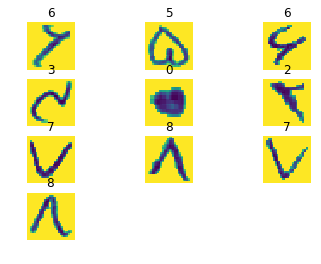

In [90]:
def visualize(dataset,labels,size = 10) :
    samples = np.random.randint(len(dataset),size=size)
    for i,sample in enumerate(samples) :
        plt.subplot(np.ceil(np.sqrt(size)),np.floor(np.sqrt(size)),1+i)
        plt.axis('off')
        plt.title(labels[sample])
        plt.imshow(dataset[sample])
visualize(data,labels,10)

In [8]:
def reformat(data,labels) :
    data = np.array(data).reshape((-1,image_size,image_size,1)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None].astype(np.float32))
    return data,labels

In [9]:
data,labels = reformat(data,labels)
print('shape of data : {}'.format(data.shape))
print('shape of labels : {}'.format(labels.shape))

shape of data : (9653, 28, 28, 1)
shape of labels : (9653, 10)


In [10]:
def train_valid_test_spliter(data,labels) :
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    return X_train,y_train,X_val,y_val,X_test,y_test

In [11]:
X_train,y_train,X_val,y_val,X_test,y_test = train_valid_test_spliter(data,labels)

In [12]:
print('train data shape: {}'.format(X_train.shape))
print('train labels shape: {}'.format(X_train.shape))
print('valid data shape : {}'.format(X_val.shape))
print('valid labels shape: {}'.format(y_val.shape))
print('test data shape : {}'.format(X_test.shape))
print('test labels shape: {}'.format(y_test.shape))

train data shape: (6177, 28, 28, 1)
train labels shape: (6177, 28, 28, 1)
valid data shape : (1545, 28, 28, 1)
valid labels shape: (1545, 10)
test data shape : (1931, 28, 28, 1)
test labels shape: (1931, 10)


## Model Implementation

In [13]:
def conv_model(input_shape) :
    
    model = Sequential()
    model.add(Conv2D(16, 5, padding='same', activation='selu', input_shape=input_shape))
    model.add(Conv2D(16, 5, padding='same', activation='selu'))
    model.add(Conv2D(16, 5, padding='same', activation='selu'))
    model.add(Conv2D(16, 5, padding='same', activation='selu'))
    model.add(Conv2D(16, 5, padding='same', activation='selu'))
    model.add(Conv2D(16, 5, padding='same', activation='selu'))
    model.add(Conv2D(16, 5, padding='same', activation='selu'))
    model.add(Conv2D(16, 5, padding='same', activation='selu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(32, 3, padding='same', activation='selu'))
    model.add(Conv2D(32, 3, padding='same', activation='selu'))
    model.add(Conv2D(32, 3, padding='same', activation='selu'))
    model.add(Conv2D(32, 3, padding='same', activation='selu'))
    model.add(Conv2D(32, 3, padding='same', activation='selu'))
    model.add(Conv2D(32, 3, padding='same', activation='selu'))
    model.add(Conv2D(32, 3, padding='same', activation='selu'))
    model.add(Conv2D(32, 3, padding='same', activation='selu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(64, 3, padding='same', activation='selu'))
    model.add(Conv2D(64, 3, padding='same', activation='selu'))
    model.add(Conv2D(64, 3, padding='same', activation='selu'))
    model.add(Conv2D(64, 3, padding='same', activation='selu'))
    model.add(Conv2D(64, 3, padding='same', activation='selu'))
    model.add(Conv2D(64, 3, padding='same', activation='selu'))
    model.add(Conv2D(64, 3, padding='same', activation='selu'))
    model.add(Conv2D(64, 3, padding='same', activation='selu'))
    model.add(AveragePooling2D())

    model.add(Flatten())

    model.add(Dense(1024, activation='selu'))
    model.add(Dense(1024, activation='selu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

## Training

In [27]:
def train_model(input_shape,X_train,y_train,X_val,y_val,batch_size=64,epochs=100,model_name = 'conv_model.h5') :
    model_path = os.path.join(model_save_path,model_name)
    if os.path.exists(model_path) :
        print('model already exist in : {}'.format(model_path))
        return load_model(model_path)
    else :
        model = conv_model(input_shape)
        model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(X_val,y_val))
        return model

In [29]:
model = train_model((image_size,image_size,1),X_train,y_train,
                    X_val,y_val,64,40,'conv_model.h5')

model already exist in : ./models/conv_model.h5


## Model Evaluation

In [30]:
scores = model.evaluate(X_test,y_test)

1931/1931 [==============================] - 2s 827us/step


In [31]:
print("Accuracy : %{}".format(scores[1]*100))
print("Error : %{}".format(100 - scores[1]*100))

Accuracy : %98.65354738477473
Error : %1.3464526152252745


## Prediction

In [93]:
def predict_image(prediction_root,image_size,model) :
    for i,path in enumerate(os.listdir(prediction_root)):
        photoes_path = os.path.join(prediction_root,path)
        photoes = os.listdir(photoes_path)
        photo_path = np.random.choice(photoes)
        processed_image = (np.array(Image.open(os.path.join(photoes_path, photo_path)).resize((image_size,image_size))).astype(float) - 
                            255.0 / 2) / 255.0
        photo = np.array(Image.open(os.path.join(photoes_path,photo_path)).resize((image_size,image_size))).astype(np.float)
        plt.subplot(np.ceil(np.sqrt(10)),np.floor(np.sqrt(10)),1+i)
        plt.axis('off')
        plt.title(np.argmax(model.predict(processed_image.reshape(1,image_size,image_size,1))))
        plt.imshow(photo)

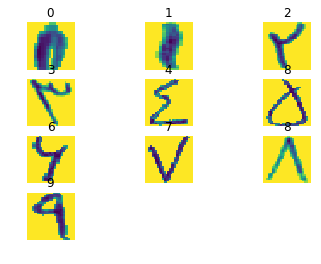

In [96]:
predict_image(prediction_root,image_size,model)